In [1]:
import glob
import numpy as np
from natsort import natsorted # type: ignore
import matplotlib.pyplot as plt


# Base directory where the folders are located
base_directory = 'results30x10'

# Use glob to find all .txt files in the directory and subdirectories
file_paths = glob.glob(f'{base_directory}/{base_directory}_*/*.txt', recursive=True)
file_paths = natsorted(file_paths)

# Function to read all .txt files
def read_all_txt_files(file_paths):
    data = []
    for file_path in file_paths:
        file_data = np.loadtxt(file_path)
        data.append((file_data))
    return data

# Read all .txt files and store their content
s = np.array(read_all_txt_files(file_paths))
np.savetxt('slowness30x10.csv', s, delimiter=',', fmt='%.12f')

data = [s[i::10] for i in range(10)]
data = np.array(data)
velocity_inversion = 1/data

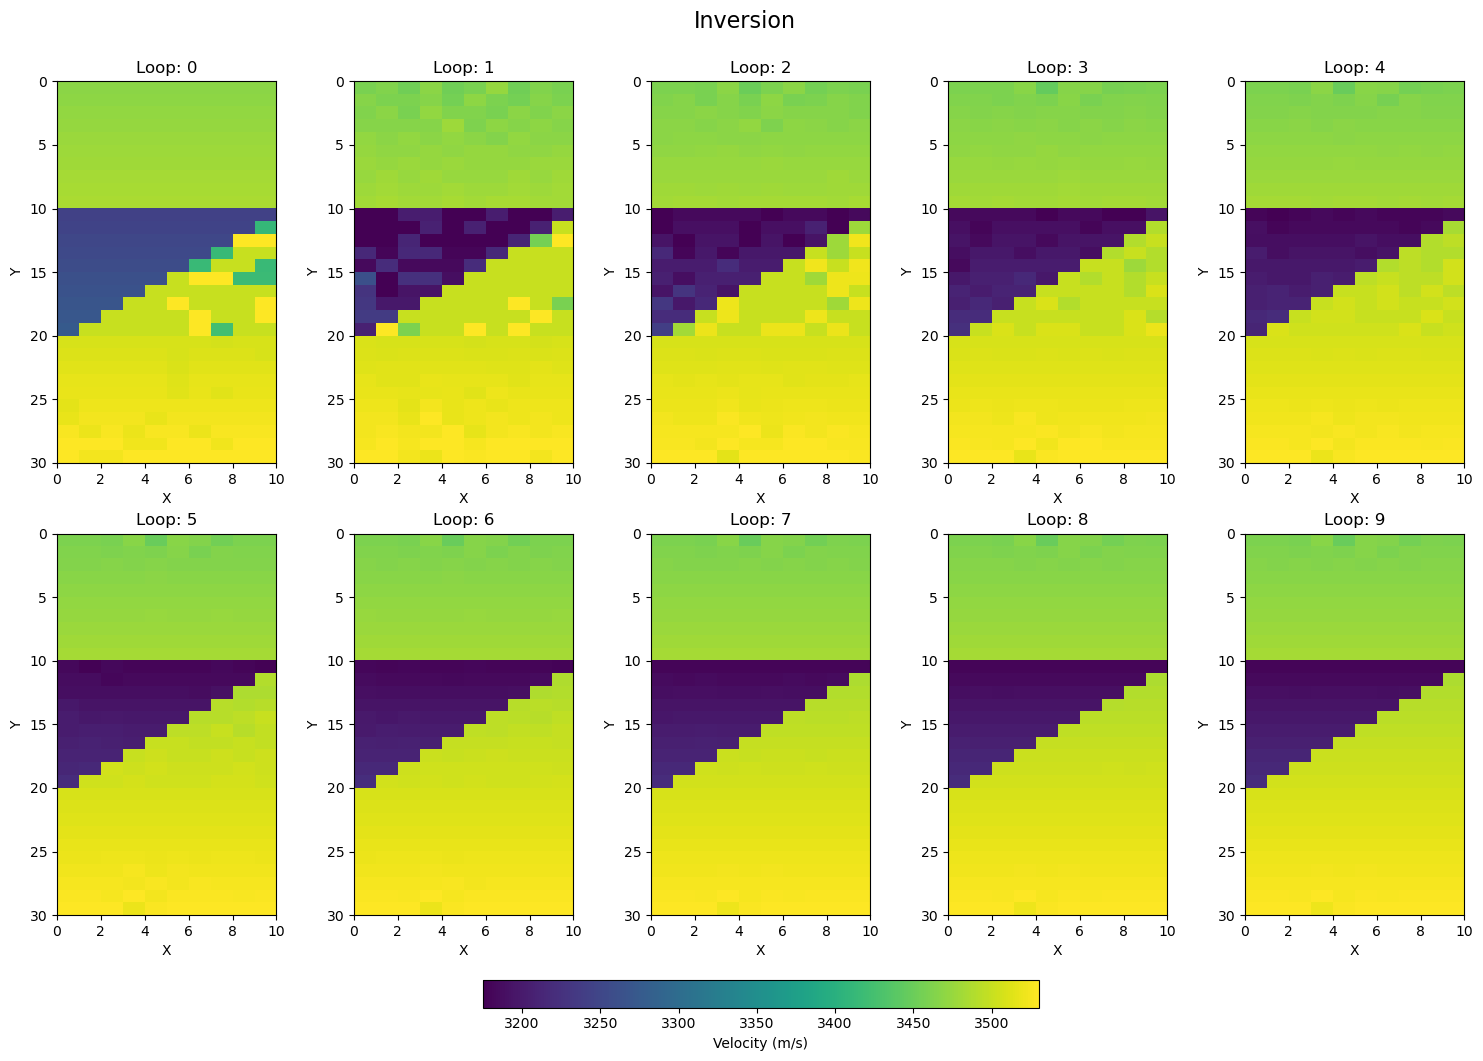

In [2]:
# Create a 2x5 grid to display the matrices using imshow
cols = 5  # Number of columns
rows = 2  # Number of rows

fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

vmin, vmax = 3175, 3530


# Loop through each matrix and plot
for i, data in enumerate(velocity_inversion):
    # Plot the data
    im = axes[i].imshow(data, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax, extent=[0, 10, 30, 0])
    axes[i].set_title(f'Loop: {i}')
    axes[i].set_xlabel('X')
    axes[i].set_ylabel('Y')

# Adjust the layout to make room for the colorbar at the bottom
fig.tight_layout(rect=[0, 0.1, 1, 0.95])

# Add a single colorbar for all subplots at the bottom
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.03, pad=0.07)
cbar.set_label('Velocity (m/s)')

# Add a title for the entire plot
fig.suptitle('Inversion', fontsize=16)

plt.show()

Text(0, 0.5, 'Y')

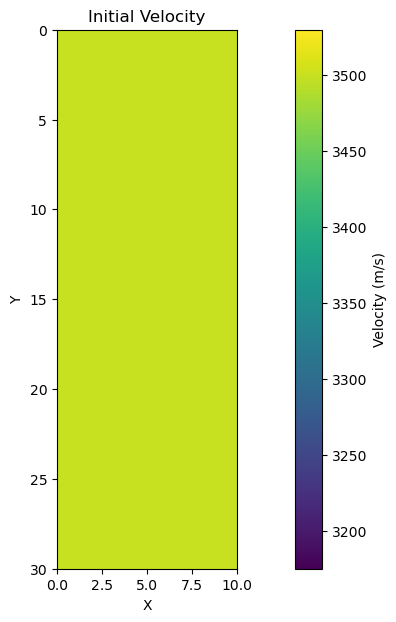

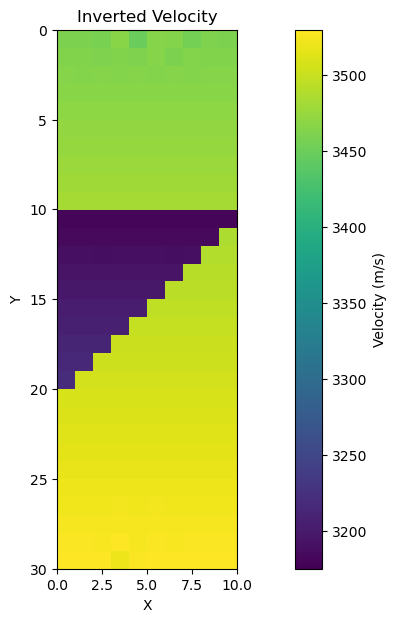

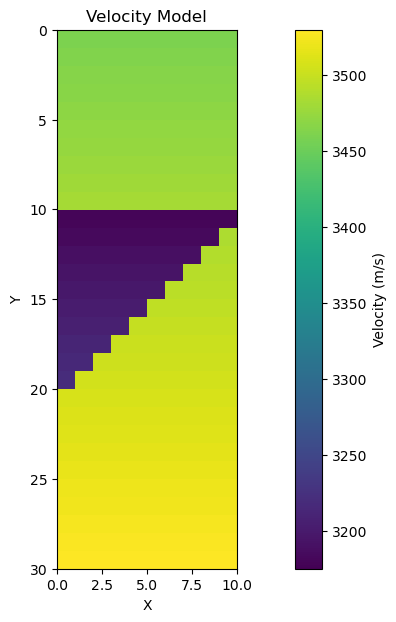

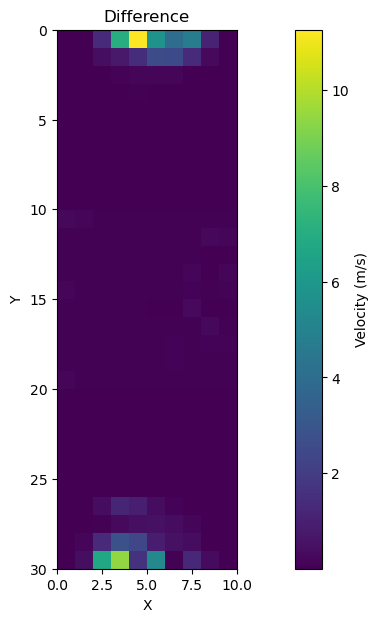

In [3]:
# define models
rows, cols = 30, 10
grid_size = (rows, cols)
min_velocity = 3460
max_velocity = 3530
wedge_min_velocity = 3180
wedge_max_velocity = 3220
wedge_start_row = 10
wedge_end_row = 20

# Create a background velocity model with values ranging from 3460 to 3530
velocity_model = np.linspace(min_velocity, max_velocity, rows).reshape(-1, 1)
velocity_model = np.repeat(velocity_model, cols, axis=1)
velocity_initial = np.full((30, 10), 3500)


# Create a triangular wedge shape with vertices at (0, 10), (0, 20), and (10, 10)
for i in range(wedge_start_row, wedge_end_row):
    row_velocity = np.linspace(wedge_min_velocity, wedge_max_velocity, wedge_end_row - wedge_start_row)[i - wedge_start_row]
    num_cols_in_wedge = wedge_end_row - i
    velocity_model[i, :num_cols_in_wedge] = row_velocity

plt.figure(figsize=(15, 7))  
plt.imshow(velocity_initial, cmap='viridis', interpolation='nearest', extent=[0, cols, rows, 0], origin='upper', vmin=3175, vmax=3530)
plt.colorbar(label='Velocity (m/s)')
plt.title('Initial Velocity')
plt.xlabel('X')
plt.ylabel('Y')

plt.figure(figsize=(15, 7))  
plt.imshow(velocity_inversion[9], cmap='viridis', interpolation='nearest', extent=[0, cols, rows, 0], origin='upper', vmin=3175, vmax=3530)
plt.colorbar(label='Velocity (m/s)')
plt.title('Inverted Velocity')
plt.xlabel('X')
plt.ylabel('Y')

plt.figure(figsize=(15, 7))  
plt.imshow(velocity_model, cmap='viridis', interpolation='nearest', extent=[0, cols, rows, 0], origin='upper', vmin=3175, vmax=3530)
plt.colorbar(label='Velocity (m/s)')
plt.title('Velocity Model')
plt.xlabel('X')
plt.ylabel('Y')

plt.figure(figsize=(15, 7))  
plt.imshow(np.abs(velocity_model-velocity_inversion[9]), cmap='viridis', interpolation='nearest', extent=[0, cols, rows, 0], origin='upper')
plt.colorbar(label='Velocity (m/s)')
plt.title('Difference')
plt.xlabel('X')
plt.ylabel('Y')

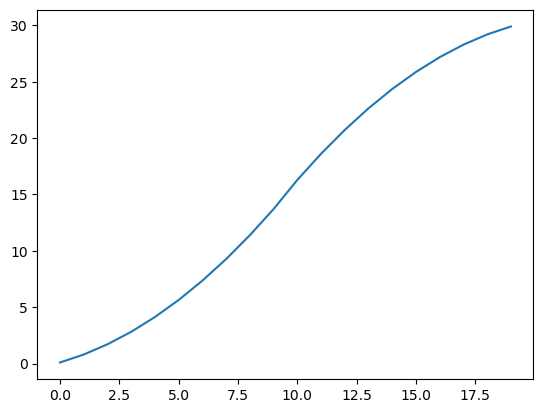

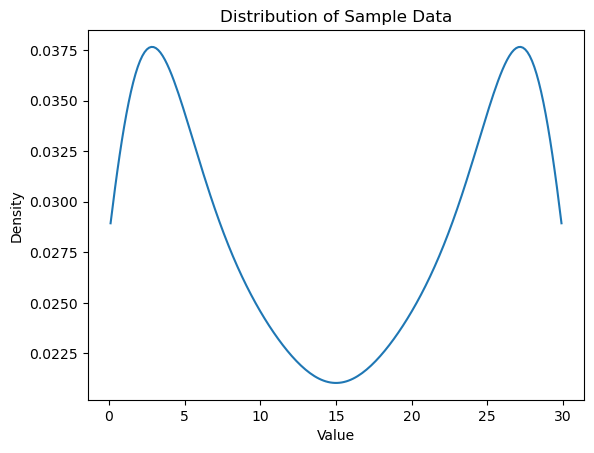

In [9]:
from scipy.stats import gaussian_kde

def rescale(arr, new_min, new_max):
    old_min = np.min(arr)
    old_max = np.max(arr)
    return (new_max - new_min) * (arr - old_min) / (old_max - old_min) + new_min

def device_location(n, rows, new_min, new_max, linear):
    if linear == True:
        z4 = np.linspace(new_min, new_max, n)
    else:
        n2 = int(np.ceil(n/2))
        rows2 = rows/2 - 1.3
        x = np.array([x for x in range(n2)])
        y = np.array([(i+3)**2 for i in x])
        z = (y - y[0]) * rows2 / (y[-1] - y[0])
        z1 = 15 - z + 15
        z2 = z1[::-1]
        z3 = np.concatenate((z, z2))
        z4 = rescale(z3, new_min, new_max) # Rescale array to range
    return z4

# Define sources and receivers
# 0.1 and 29.9 are values close to limits
# Change linear to True to generate regular locations

# NOTE: create the z position not on the grid boundary to avoid conflict
z = device_location(n=20, rows=rows, new_min=0.1, new_max=29.9, linear=False)

plt.plot(z)
z

# Calculate the point density
density = gaussian_kde(z)
xs = np.linspace(min(z), max(z), 200)
density.covariance_factor = lambda : .25
density._compute_covariance()

# Plot distribution
plt.figure()
plt.plot(xs, density(xs))
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution of Sample Data')
plt.show()